In [ ]:
import numpy as np
import torch
import timeit
import os
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd


from tqdm.notebook import tqdm
from google.colab import drive
import sys

drive.mount("/content/gdrive")
path = "/content/gdrive/My Drive/Colab Notebooks/GANS/Gan V4: Progressive Growing"

sys.path.append(path)

from src.Discriminator import Discriminator
from scr.Generator import Generator

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi

Sat Nov 21 20:35:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class Logger():
  def __init__(self, run_path):
    self.writer = SummaryWriter(log_dir=os.path.join(run_path, "TensorBoard"))
  
  def add_loss(self, disc_loss, gen_loss, step):
    self.writer.add_scalar("Discriminator Loss", disc_loss, global_step= step)
    self.writer.add_scalar("Generator Loss", gen_loss, global_step= step)
  
  def add_images(self, name, image):
    self.writer.add_image(name, image)
  
  def close(self):
    self.writer.close()

In [ ]:
def calc_gradient_penalty(netD, real_data, fake_data):
    #print real_data.size()
    batch_size = real_data.shape[0]
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand(real_data.shape).to(device)

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data))
    interpolates.requires_grad = True

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = torch.mean(((gradients.norm(2, dim=1) - 1) ** 2), dim=[0, 1, 2])
    return gradient_penalty

In [ ]:
class ProgTrainer():
  def __init__(self, 
               netG, # Generator
               netD, # Discriminator
               dataset_path = None, # Dataset Path
               dataset_class = None, # The class to be used as datasetclass
               out_res = 1024, # Out resolution
               config=None, # Configuration listing: out_res, intervals, training_schedule etc
               load_checkpoint_path = None,
               device = "cpu" # Cuda or cpu
               ):

    # Objects
    self.netG = netG
    self.netD = netD
    self.optimD = None # Either make new or load from state
    self.optimG = None
    self.dataset = None
    self.dataset_path = dataset_path
    self.dataset_class = dataset_class
    self.data_loader = None # Either make new or load from state
    self.config = config
    self.out_res = out_res
    self.device = device

    # Loss Variables
    self.Lambda = 10.0
    #self.gradient_penalty = WGANGPGradientPenalty()

    # Default Config
    if config is None: # Config determines batch size and amount of images shown during growing and stabilising
      self.config = {"interval": 800000, "4":16, "8":16, "16":16, "32":16, "64":16, "128":16, "256":14, "512":6, "1024":3}

    # State Variables
    self.schedule = self.make_schedule() # Schedule contains how many steps are required for the training of each layer
    self.cur_layer = 0 # Which layer is currently being trained e.g 0 is 4x4 stab, 1 is 8x8 growing, 2 is 8x8 stab etc.
    self.cur_step = 0 # Tracks the steps in the training of one layer
    self.growing = False # Wether the network is currently growing
    self.current_batch_size = self.config["4"] # Initial Batch size 
    self.current_res = 4

    # Fixed noise for monitoring training progress
    self.fixed_noise = self.get_noise(16, 512)

    # Load Checkpoint to resume training
    if load_checkpoint_path is not None and os.path.isfile(load_checkpoint_path): # Loads from Checkpoint
      self.load_checkpoint(load_checkpoint_path)
    
    # Sanity check that both dataset path and class exist
    assert self.dataset_class is not None and self.dataset_path is not None
    # Make dataset -> loader and optim
    self.update_loader_optim()

    if load_checkpoint_path is not None and os.path.isfile(load_checkpoint_path):
      self.load_optim(load_checkpoint_path)

    # Backward Tensors
    self.one = torch.ones(1).to(self.device)
    self.mone = -self.one


  #### Util Functions ####
  def make_schedule(self):
    training_phases = int((math.log2(self.out_res)-1)*2) # How many training phases there are, e.g 3 for 8x8 output i.e. 2x growing 1x stabilising
    
    schedule = [self.config["interval"]//self.config[str(2**((int(i)//2)+2))]  for i in range(1,training_phases)] # How many steps are required for each layer

    return schedule

  def update_loader_optim(self):
    # Resize images to appropriate size
    transform = transforms.Compose([transforms.Resize(size=[self.current_res, self.current_res]),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0, std=1)
                                    ])
    
    self.dataset = self.dataset_class(root=self.dataset_path, transform=transform)
    
    # Make dataloader with appropriate batch size, use of iter to allow iteration over non epoch intervals
    self.data_loader = iter(DataLoader(self.dataset, batch_size=self.current_batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True))

    if self.optimD is None or self.optimG is None: # If first training pass, no growing from first block
      self.optimD = optim.Adam(self.netD.parameters(), lr=0.001, betas=(0, 0.99))
      self.optimG = optim.Adam(self.netG.parameters(), lr=0.001, betas=(0, 0.99))

    else:
      self.netD.add_block()
      self.netG.add_block()

      # Move newly added blocks to device
      self.netD.to(self.device)
      self.netG.to(self.device)

      # Make new optimiser if new Block is added, ignore previous state
      self.optimD = optim.Adam(self.netD.parameters(), lr=0.001, betas=(0, 0.99))
      self.optimG = optim.Adam(self.netG.parameters(), lr=0.001, betas=(0, 0.99))

  def maintenance(self):
    if self.cur_layer >= len(self.schedule): # Sanity check to see if loop should continue or not
      return

    ## Sets growing ##
    self.growing = not self.growing

    ## Updates Batch Size ##
    state = (self.cur_layer+1)//2 # 0 for 4x4 stab + growing, 1 for 8x8 stab + growing, etc
    self.current_res = int(2**(state+2)) # calculate current resolution from state
    self.current_batch_size = self.config[str(self.current_res)] # get batch_size from config

    ## Update Loader, Optim, Net ##
    if self.growing:
      print("Updating Loader, optim")
      self.update_loader_optim()

  # Get alpha, simple division
  def get_alpha(self):
    if not self.growing:
      return 1.0
    
    alpha = self.cur_step/self.schedule[self.cur_layer]
    return alpha
 
  def load_checkpoint(self, checkpoint_path):
    state_dict = torch.load(checkpoint_path)

    # Add as many blocks as required
    for i in range((state_dict["cur_layer"]+1)//2):
      self.netG.add_block()
      self.netD.add_block()

    # Load net and opt state dicts
    self.netG.load_state_dict(state_dict["Generator"])
    self.netG.to(self.device)
    self.netD.load_state_dict(state_dict["Discriminator"])
    self.netD.to(self.device)

    # Set other variables
    self.dataset_path = state_dict["DPath"]
    self.dataset_class = state_dict["DClass"]
    self.config = state_dict["config"]
    self.out_res = state_dict["out_res"]
    self.schedule = state_dict["schedule"]
    self.cur_layer = state_dict["cur_layer"]
    self.cur_step = state_dict["cur_step"]
    self.growing = state_dict["growing"]
    self.current_batch_size = state_dict["current_batch_size"]
    self.current_res = state_dict["current_res"]

    self.fixed_noise = state_dict["fixed noise"]

  # Load Optimiser later as they're created by the class
  def load_optim(self, checkpoint_path):
    state_dict = torch.load(checkpoint_path)
    self.optimG.load_state_dict(state_dict["Optim G"])
    self.optimD.load_state_dict(state_dict["Optim D"])

  def save_checkpoint(self, path):
    name = os.path.join(path, "Layer: {} Step: {}.tar".format(self.cur_layer, self.cur_step))
    state_dict = { # Fixed Variables and Objects
                  "Generator" : self.netG.state_dict(),
                  "Discriminator" : self.netD.state_dict(),
                  "Optim D" : self.optimD.state_dict(),
                  "Optim G" : self.optimG.state_dict(),
                  "DPath" : self.dataset_path,
                  "DClass" : self.dataset_class,
                  "config" : self.config,
                  "out_res" : self.out_res,

                  # State Variables
                  "schedule" : self.schedule,
                  "cur_layer" : self.cur_layer,
                  "cur_step" : self.cur_step ,
                  "growing" : self.growing,
                  "current_batch_size" : self.current_batch_size,
                  "current_res" : self.current_res,

                  "fixed noise" : self.fixed_noise
                  }
    torch.save(state_dict, name)
    print("Saved {} succesfully".format("Layer: {} Step: {}.tar".format(self.cur_layer, self.cur_step)))


  #### Train and Step ####
  def train(self, run_path):
    logger = Logger(run_path)

    # Use of while loops to allow easy resuming, for loops would work as well but would not allow resuming from a given point
    while self.cur_layer < len(self.schedule): 
      with tqdm(total=self.schedule[self.cur_layer]) as pbar:
        while self.cur_step < self.schedule[self.cur_layer]:
        
          try:
           img = next(self.data_loader).to(device) # 
          except:
            self.data_loader = iter(DataLoader(self.dataset, batch_size=self.current_batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True))
            img = next(self.data_loader)[0].to(device)

          disc_loss, gen_loss = self.step(img, growing = self.growing, alpha=self.get_alpha())
          if self.cur_step%4 == 0:
            pbar.set_postfix_str("Layer: {}, Step: {}, Res: {}, Alpha: {:.3f}, Growing: {}, Disc_Loss: {:.4f}, Gen_Loss: {:.4f}".format(self.cur_layer,
                                                                                 self.cur_step,
                                                                                 self.current_res,
                                                                                 self.get_alpha(),
                                                                                 self.growing,
                                                                                 disc_loss, gen_loss))
          
          self.cur_step +=1
          pbar.n = self.cur_step # Allows pbar to be set to appropiate position if resuming from save
          pbar.refresh() # If resuming messes with ETA though

          # Logging
          if self.cur_step% (self.schedule[self.cur_layer]//100) == 0:
            time_step = sum(self.schedule[0:self.cur_layer]) + self.cur_step
            logger.add_loss(disc_loss, gen_loss, time_step)

          if self.cur_step% (self.schedule[self.cur_layer]//30) == 0: # Takes snapshot 40 times per layer
            fake_img = netG(self.fixed_noise).detach().cpu()
            fake_img = torchvision.utils.make_grid(fake_img.clamp(min=-1, max=1), nrow=4, scale_each=True, normalize=True)

            name = sum(self.schedule[0:self.cur_layer]) + self.cur_step
            logger.add_images(str(name), fake_img)
          
          if self.cur_step % (self.schedule[self.cur_layer]//2) == 0: # Saves 2 times per layer
            logger.close() # Save log file to disk
            logger = Logger(run_path) # Make new Logger
            self.save_checkpoint(run_path) # Save Checkpoint

          
      self.cur_step = 0
      self.cur_layer += 1

      self.maintenance()

    print("Finished")
  
  # Get noise for generator from Normal (0, 1)
  def get_noise(self, batch_size, latent_size):
    return torch.randn(batch_size, latent_size).to(self.device)

  # Generator and Discriminator step
  def step(self, img, growing=False, alpha=1.0):
    batch_size = img.shape[0]

    # Discriminator Step 
    for p in netD.parameters():
        p.requires_grad = True

    real_logits = self.netD(img, growing = growing, alpha= alpha)
    real_loss = torch.mean(real_logits, 0)

    real_loss = real_loss - 1e-4 * torch.square(real_loss) # - Correction term 
    real_loss.backward(self.mone) # Multiply with -1 => gets correct sign

    with torch.no_grad():
      noise = self.get_noise(batch_size, 512)
      fake_img = self.netG(noise, growing = growing, alpha = alpha)

    fake_logits = self.netD(fake_img, growing = growing, alpha = alpha)
    fake_loss = torch.mean(fake_logits, 0)
    fake_loss.backward(self.one) # Add to previous loss

    gradient_penalty = calc_gradient_penalty(netD, img.detach(), fake_img.detach()) * 10
    gradient_penalty.backward() # Add gradient penalty

    Wasserstein_Loss = real_loss - fake_loss   

    # Update weights
    self.optimD.step()

    # Generator Step
    for p in netD.parameters():
        p.requires_grad = False  # to avoid computation
    
    netG.zero_grad()

    noise = self.get_noise(batch_size, 512)
    fake_img = self.netG(noise, growing = growing)
    fake_logits = self.netD(fake_img, growing = growing)
    fake_loss = torch.mean(fake_logits, 0)
    fake_loss.backward(self.mone)
    gen_loss = -fake_loss
    
    self.optimG.step()

    return Wasserstein_Loss.item(), gen_loss.item()

In [ ]:
root = "FashionMNIST"
transform = transforms.Compose([transforms.ToTensor()])
dset = torchvision.datasets.FashionMNIST(root, transform=transform, download=True)

In [ ]:
device = "cuda"

netG = Generator(out_dim=1, out_res=32).to(device)
netD = Discriminator(in_dim=1).to(device)
config = {"interval":150000, "4":16, "8":16, "16":16, "32":16}

run_path = os.path.join(os.path.join(path, "Run 1"))

pTrainer = ProgTrainer(netG, netD, dataset_path=root, dataset_class=torchvision.datasets.FashionMNIST,
                       device = device, config=config, out_res=32, )#load_checkpoint_path = os.path.join(run_path, "Layer: 1 Step: 5000.tar"))

512 512
512 512
512 512


In [ ]:
pTrainer.train(run_path)

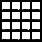

In [ ]:
toPIL = transforms.ToPILImage(mode="RGB")

noise = pTrainer.get_noise(16, 512)
img = netG(noise).cpu()
img = torchvision.utils.make_grid(img.clamp(min=-1, max=1), nrow=4, scale_each=True, normalize=True)
img = toPIL(img)
img